# Perturbation Theory

In this notebook, we compare the perturbation theory calculations with the ones from the vGH Ansatz.

In [1]:
import numpy as np
import autograd.numpy as np
from autograd import grad

import scipy
import matplotlib.pyplot as plt
import time, os, sys, gc

import h5py 

import svgutils.transform as sg 
import sys 

import matplotlib.patches as patches

from scipy.integrate import solve_ivp

import class_energy as energy
import class_equations_of_motion as eom 

import class_handle_input as h_in
import class_handle_wavefunctions as h_wavef

import class_visualization as vis
import class_mass_size as mass_size

### Self Energy expression

We compute the self-energy obtained from the perturbative Ansatz and find the energy that fulfills the self-consistent equation.

In [2]:
def integrate_self_energy(V_0, tx, ty, B, E):
    E_self = lambda kx, ky: (2*V_0**2)/(4*np.pi**2)*(1-np.cos(kx)*np.cos(ky))/(B-E-2*tx*np.cos(kx)-2*ty*np.cos(ky))
    E_self_int = scipy.integrate.dblquad(E_self, -np.pi,np.pi, -np.pi,np.pi)
    return E_self_int

def find_Ep(V_0, tx, ty, B, E_guess):
    E_self_int = lambda E: E+integrate_self_energy(V_0, tx, ty, B, E-2*tx-2*ty)[0]
    E_min = scipy.optimize.fsolve(E_self_int, [E_guess])
    return E_min

def find_first_deriv_self_energy(V_0, tx, ty, B, h):
    E_min = find_Ep(V_0, tx, ty, B, guess_Ep(V_0))

    E_self_int = lambda E: integrate_self_energy(V_0, tx, ty, B, E-2*tx-2*ty)[0].real

    x = E_min
    
    E_min_prime = (-E_self_int(x + 2*h) + 8*E_self_int(x + h) - 8*E_self_int(x - h) + E_self_int(x - 2*h)) / (12 * h)
    
    #E_self_int_prime = grad(E_self_int)

    #E_min_prime = E_self_int_prime(E_min)
    return E_min_prime
    
def guess_Ep(V_0):
    return -0.004649*V_0**2-0.07471*V_0+0.8718

Here we define functions that compute the vGH and perturbative energies for different potentials.

In [3]:
def quick_pot_scan(params, V_0_arr, folder):
    h5_io_object = h_in.io_hdf5()

    print('\nvGH Calculations:')
    E_arr = np.zeros(len(V_0_arr), dtype=complex)
    for i in range(len(V_0_arr)):
        print('V0 =', V_0_arr[i])
        params["V_0"] = V_0_arr[i]

        eom_object = eom.eom(params=params)
        wavefunc_object = h_wavef.wavefunctions(params=params)
        wfn_manip = h_wavef.wavefunc_operations(params=params)
        ''' 
        Init wavefunction
        '''
        psi_init = wavefunc_object.create_init_wavefunction(params['init_choice'])
        psi_init = wfn_manip.reshape_one_dim(psi_init)
        ''' 
        Imaginary Time Propagation
        '''
        psi, E_evo, epsilon_evo = eom_object.solve_for_fixed_params_imag_time_prop_new(psi_init)
        E_arr[i] = E_evo[-1]

        h5_io_object.save_calculation_run(psi, E_evo, epsilon_evo, params, folder)

    return E_arr

def pert_pot_scan(params, V_0_arr):
    print('\nPerturbative Calculations:')
    E_arr = np.zeros(len(V_0_arr), dtype=complex)
    for i in range(len(V_0_arr)):
        E_min = find_Ep(V_0_arr[i], params["tx"], params["ty"], params["B"], guess_Ep(V_0_arr[i]))
        E_arr[i] = E_min[0]
        print('V0 =', V_0_arr[i], ', E =', E_arr[i])
        
    return E_arr

def get_Ep_from_E_vGH(E_vGH, tx, ty):
    return E_vGH+2*tx+2*ty

def get_E_from_Ep(E_vGH, tx, ty):
    return E_vGH-2*tx-2*ty

def get_E_arr(V_0_range, folder, check_sys, check_sym):
    h5_io_object = h_in.io_hdf5()
    
    E_arr = np.zeros(len(V_0_range), dtype=complex)
    for i in range(len(V_0_range)):
        check_sys_n = check_sys+'_V0_'+str(V_0_range[i])
        file_list = [f for f in os.listdir(folder) if check_sys_n in f and check_sym in f]
        
        if len(file_list) > 1: 
            break
        for file in file_list:
            file_name = folder+file
            psi, params = h5_io_object.get_psi(file_name)

            energy_object = energy.energy(params=params)
            E, E_T, E_B, E_V = energy_object.calc_energy(psi)
            E_arr[i] = E
    return E_arr

In [4]:
def calc_eff_mass(self_E_prime, V_0, tx, ty, B):
    kx = 0
    ky = 0
    
    sec_deriv_band_x = 2*tx*np.cos(kx)
    sec_deriv_band_y = 2*ty*np.cos(ky)
    
    eff_mass_x = (1+self_E_prime)/sec_deriv_band_x
    eff_mass_y = (1+self_E_prime)/sec_deriv_band_y
    return eff_mass_x, eff_mass_y

### Define the calculation parameters

In [5]:
params = {"n": 256,
"M": 36,
"Mx": 16,
"Mx_display": 4,
"converge_new_lattice": "no",
"My": 16,
"My_display": 4,
"B": 1.0,
"tx": 100,
"ty": 100,
"V_0": 150.0,
"qx": 0,
"qy": 0,
"init_choice": "uniform",
"external_wf_tag": " ",
"excitation_no": 11,
"angle_pattern": [0,0,0,0],
"V_0_pattern": [0,0,0,0],
"n_states": 0,
"path_to_input_wavefunction": " ",
"dt": 0.001,
"tol": 1e-10}

x = (2*np.pi/params["n"])*np.arange(params["n"])

''' 
I/O Object
'''
h5_io_object = h_in.io_hdf5()

### Perturbation Energies

In [6]:
V_0_range1 = np.linspace(0,10,21) 
V_0_range2 = np.linspace(15,100,18)

V_0_range = np.append(V_0_range1, V_0_range2)

In [7]:
#V_0_range = np.linspace(0,100,21)

params["B"] = 1.0
params["tx"] = 100
params["ty"] = 100
t = params["tx"] + params["ty"]
Ep_pert1_B_1 = pert_pot_scan(params, V_0_range)
E_pert1_B_1 = get_E_from_Ep(Ep_pert1_B_1, params["tx"], params["ty"])

params["B"] = 200.0
Ep_pert1_B_200 = pert_pot_scan(params, V_0_range)
E_pert1_B_200 = get_E_from_Ep(Ep_pert1_B_200, params["tx"], params["ty"])



params["B"] = 1.0
params["tx"] = 50
params["ty"] = 150
Ep_pert2_B_1 = pert_pot_scan(params, V_0_range)
E_pert2_B_1 = get_E_from_Ep(Ep_pert2_B_1, params["tx"], params["ty"])

params["B"] = 200.0
Ep_pert2_B_200 = pert_pot_scan(params, V_0_range)
E_pert2_B_200 = get_E_from_Ep(Ep_pert2_B_200, params["tx"], params["ty"])



params["B"] = 1.0
params["tx"] = 10
params["ty"] = 190
Ep_pert3_B_1 = pert_pot_scan(params, V_0_range)
E_pert3_B_1 = get_E_from_Ep(Ep_pert3_B_1, params["tx"], params["ty"])

params["B"] = 200.0
params["tx"] = 10
params["ty"] = 190
Ep_pert3_B_200 = pert_pot_scan(params, V_0_range)
E_pert3_B_200 = get_E_from_Ep(Ep_pert3_B_200, params["tx"], params["ty"])


Perturbative Calculations:
V0 = 0.0 , E = 0j
V0 = 0.5 , E = (-0.0015774701930992587+0j)
V0 = 1.0 , E = (-0.00630965254400675+0j)
V0 = 1.5 , E = (-0.014195863338946384+0j)
V0 = 2.0 , E = (-0.025234966265329596+0j)
V0 = 2.5 , E = (-0.039425377132477894+0j)
V0 = 3.0 , E = (-0.05676507029911911+0j)
V0 = 3.5 , E = (-0.07725158663945983+0j)
V0 = 4.0 , E = (-0.10088204285190014+0j)
V0 = 4.5 , E = (-0.12765314189619664+0j)
V0 = 5.0 , E = (-0.15756118433857913+0j)
V0 = 5.5 , E = (-0.19060208038760648+0j)
V0 = 6.0 , E = (-0.2267713624153777+0j)
V0 = 6.5 , E = (-0.2660641977765987+0j)
V0 = 7.0 , E = (-0.30847540176007604+0j)
V0 = 7.5 , E = (-0.3539994505313079+0j)
V0 = 8.0 , E = (-0.40263049394941136+0j)
V0 = 8.5 , E = (-0.4543623681651993+0j)
V0 = 9.0 , E = (-0.5091886079289124+0j)
V0 = 9.5 , E = (-0.5671024585554438+0j)
V0 = 10.0 , E = (-0.6280968875135562+0j)
V0 = 15.0 , E = (-1.4057483402862088+0j)
V0 = 20.0 , E = (-2.4820391863270785+0j)
V0 = 25.0 , E = (-3.84675875098263+0j)
V0 = 30.0 , E 

### vGH energies

#### Note: for big lattices, it is better to use the stand-alone python script! This cell is just suited for quick computations

In [6]:
V_0_range = np.linspace(0,100,21)

params["B"] = 1.0
params["tx"] = 100
params["ty"] = 100
folder = 'results/perturbation_theory/tx_100_ty_100/'
E_vGH1 = quick_pot_scan(params, V_0_range, folder)

params["B"] = 10.0
E_vGH1_B_10 = quick_pot_scan(params, V_0_range, folder)

params["B"] = 1.0
params["tx"] = 50
params["ty"] = 150
folder = 'results/perturbation_theory/tx_50_ty_150/'
E_vGH2 = quick_pot_scan(params, V_0_range, folder)

params["B"] = 1.0
params["tx"] = 10
params["ty"] = 190
folder = 'results/perturbation_theory/tx_10_ty_190/'
E_vGH3 = quick_pot_scan(params, V_0_range, folder)



vGH Calculations:
V0 = 0.0
V0 = 5.0


KeyboardInterrupt: 

Read in the vGH calculations from the wavefunctions.

In [8]:
check_sys = 'tx_100_ty_100'
check_sym = '_B_1.0_Mx_'+str(params["Mx"])+'_My_'+str(params["My"])
folder = 'results/perturbation_theory/tx_100_ty_100/'
E_vGH1_B_1 = get_E_arr(V_0_range, folder, check_sys, check_sym)

check_sym = '_B_200.0_Mx_'+str(params["Mx"])+'_My_'+str(params["My"])
folder = 'results/perturbation_theory/tx_100_ty_100/'
E_vGH1_B_200 = get_E_arr(V_0_range, folder, check_sys, check_sym)



check_sys = 'tx_50_ty_150'
check_sym = '_B_1.0_Mx_'+str(params["Mx"])+'_My_'+str(params["My"])
folder = 'results/perturbation_theory/tx_50_ty_150/'
E_vGH2_B_1 = get_E_arr(V_0_range, folder, check_sys, check_sym)

check_sys = 'tx_50_ty_150'
check_sym = '_B_200.0_Mx_'+str(params["Mx"])+'_My_'+str(params["My"])
folder = 'results/perturbation_theory/tx_50_ty_150/'
E_vGH2_B_200 = get_E_arr(V_0_range, folder, check_sys, check_sym)



check_sys = 'tx_10_ty_190'
check_sym = '_B_1.0_Mx_'+str(params["Mx"])+'_My_'+str(params["My"])
folder = 'results/perturbation_theory/tx_10_ty_190/'
E_vGH3_B_1 = get_E_arr(V_0_range, folder, check_sys, check_sym)

check_sys = 'tx_10_ty_190'
check_sym = '_B_200.0_Mx_'+str(params["Mx"])+'_My_'+str(params["My"])
folder = 'results/perturbation_theory/tx_10_ty_190/'
E_vGH3_B_200 = get_E_arr(V_0_range, folder, check_sys, check_sym)

## Plot the results to show how the energies match!

In [9]:
def E_to_plot(E, t):
    return np.abs(E+2*t)/t

In [14]:
E_pert1_B_1-(E_vGH1_B_1-0.0017)

array([1.70000000e-03+0.00000000e+00j, 1.62953143e-03-1.15970147e-22j,
       1.51684673e-03+7.19272057e-23j, 1.40070609e-03+1.35760839e-21j,
       1.27309034e-03-1.08882507e-21j, 1.13061944e-03+1.72680690e-21j,
       9.92420010e-04-2.06627959e-21j, 8.62822612e-04-3.00031728e-21j,
       7.45526220e-04-2.84096998e-21j, 6.14836119e-04-3.28068891e-21j,
       5.31569193e-04+1.68450397e-20j, 4.39474602e-04+5.15299513e-21j,
       3.72440273e-04+1.22189561e-20j, 3.35381634e-04-1.41846095e-20j,
       3.33430324e-04+2.40002789e-20j, 3.71967393e-04-2.93923843e-20j,
       4.18401283e-04+1.73428884e-20j, 5.54934596e-04+4.10178094e-20j,
       7.10007753e-04+8.74342821e-22j, 9.70277443e-04-3.18552304e-20j,
       1.26161722e-03-3.35657291e-20j, 9.87081910e-03+7.51122115e-20j,
       3.51860375e-02+1.00405574e-19j, 8.80276886e-02-3.01610792e-19j,
       1.80600001e-01+1.80267057e-19j, 3.26022252e-01+2.98910340e-19j,
       5.37941954e-01-7.52928435e-19j, 8.30335880e-01-8.72971367e-19j,
      

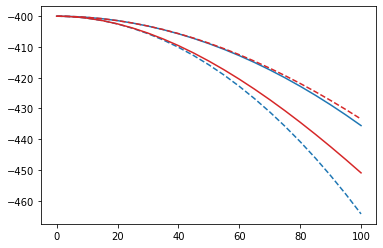

In [15]:
plt.plot(V_0_range, E_vGH1_B_1.real, color='tab:blue', linestyle='dashed')
plt.plot(V_0_range, E_vGH1_B_200.real, color='tab:blue')
plt.plot(V_0_range, E_pert1_B_1.real, color='tab:red')
plt.plot(V_0_range, E_pert1_B_200.real, color='tab:red', linestyle='dashed')
#plt.plot(V_0_range, E_pert3.real, color='tab:red')
#plt.plot(V_0_range, E_vGH3.real, color='tab:blue')

#plt.xscale('log')
#plt.yscale('log')

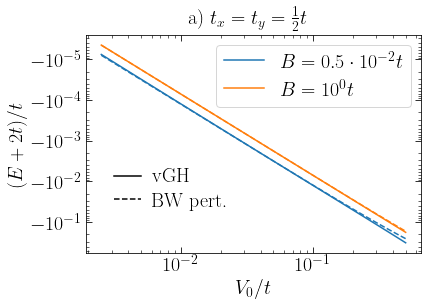

In [15]:
A = 6
plt.rc('figure', figsize=[46.82 * .5**(.5 * A), 33.11 * .5**(.5 * A)])
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
font_size = 20

fig, axs = plt.subplots()

plt.suptitle(r'a) $t_x=t_y=\frac{1}{2}t$', fontsize=font_size)

axs.plot(V_0_range[1:]/t, E_to_plot(E_vGH1_B_1.real,t)[1:], color='tab:blue', linestyle='solid', label=r'$B = 0.5\cdot 10^{-2} t$')
axs.plot(V_0_range[1:]/t, E_to_plot(E_pert1_B_1.real,t)[1:], color='tab:blue', linestyle='dashed')

axs.plot(V_0_range[1:]/t, E_to_plot(E_vGH1_B_200.real,t)[1:], color='tab:orange', linestyle='solid', label=r'$B = 10^0 t$')
axs.plot(V_0_range[1:]/t, E_to_plot(E_pert1_B_200.real,t)[1:], color='tab:orange', linestyle='dashed')

plt.xlabel(r'$V_0/t$', fontsize=font_size)
plt.ylabel(r'$(E+2t)/t$', fontsize=font_size)

plt.xticks(fontsize=font_size)

axs.set_xscale('log', base=10)
axs.set_yscale('log', base=10)

axs.invert_yaxis()
axs.set_yticks([1e-1,1e-2,1e-3,1e-4,1e-5],[r'$-10^{-1}$',r'$-10^{-2}$',r'$-10^{-3}$',r'$-10^{-4}$',r'$-10^{-5}$'], fontsize=font_size)

axs.plot(np.linspace(3.1e-3,5e-3,100), 0.75e-2*np.ones(100), linestyle='solid', color='black')
axs.plot(np.linspace(3.1e-3,5e-3,100), 0.27e-1*np.ones(100), linestyle='dashed', color='black')

axs.annotate('vGH', xy=(0.6*1e-2,1e-2), fontsize=font_size)
axs.annotate('BW pert.', xy=(0.6*1e-2,0.4e-1), fontsize=font_size)

axs.legend(fontsize=font_size, loc=1)

plt.tick_params(axis='x', direction='in', length=6, top=True)
plt.tick_params(axis='y', direction='in', length=6, right=True)
plt.tick_params(axis='x', which='minor', direction='in', length=3, top=True)
plt.tick_params(axis='y', which='minor', direction='in', length=3, right=True)

plt.tick_params(which='minor', axis='y', direction='in', right=True)

plt.savefig('results/perturbation_theory/B_comp_tx_100_ty_100.svg', bbox_inches='tight')

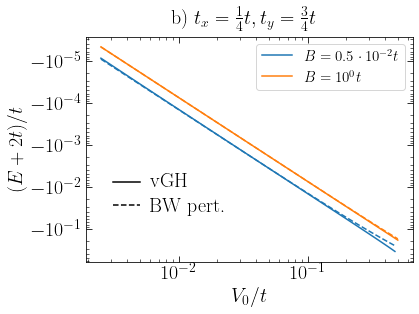

In [16]:
A = 6
plt.rc('figure', figsize=[46.82 * .5**(.5 * A), 33.11 * .5**(.5 * A)])
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
font_size = 20

fig, axs = plt.subplots()

plt.suptitle(r'b) $t_x=\frac{1}{4}t,t_y=\frac{3}{4}t$', fontsize=font_size)

axs.plot(V_0_range[1:len(E_vGH2_B_1)-1]/t, E_to_plot(E_vGH2_B_1.real[1:len(E_vGH2_B_1)-1],t), color='tab:blue', linestyle='solid', label=r'$B = 0.5\cdot 10^{-2} t$')
axs.plot(V_0_range[1:len(E_vGH2_B_1)-1]/t, E_to_plot(E_pert2_B_1.real[1:len(E_vGH2_B_1)-1],t), color='tab:blue', linestyle='dashed')

axs.plot(V_0_range[1:]/t, E_to_plot(E_vGH2_B_200.real,t)[1:], color='tab:orange', linestyle='solid', label=r'$B = 10^0 t$')
axs.plot(V_0_range[1:]/t, E_to_plot(E_pert2_B_200.real,t)[1:], color='tab:orange', linestyle='dashed')

plt.xlabel(r'$V_0/t$', fontsize=font_size)
plt.ylabel(r'$(E+2t)/t$', fontsize=font_size)


plt.xticks(fontsize=font_size)
plt.yticks(fontsize=font_size)

axs.set_xscale('log', base=10)
axs.set_yscale('log', base=10)

axs.invert_yaxis()
axs.set_yticks([1e-1,1e-2,1e-3,1e-4,1e-5],[r'$-10^{-1}$',r'$-10^{-2}$',r'$-10^{-3}$',r'$-10^{-4}$',r'$-10^{-5}$'], fontsize=font_size)

axs.plot(np.linspace(3.1e-3,5e-3,100), 0.75e-2*np.ones(100), linestyle='solid', color='black')
axs.plot(np.linspace(3.1e-3,5e-3,100), 0.27e-1*np.ones(100), linestyle='dashed', color='black')

axs.annotate('vGH', xy=(0.6*1e-2,1e-2), fontsize=font_size)
axs.annotate('BW pert.', xy=(0.6*1e-2,0.4e-1), fontsize=font_size)

axs.legend(fontsize=15, loc=1)

plt.tick_params(axis='x', direction='in', length=6, top=True)
plt.tick_params(axis='y', direction='in', length=6, right=True)
plt.tick_params(axis='x', which='minor', direction='in', length=3, top=True)
plt.tick_params(axis='y', which='minor', direction='in', length=3, right=True)

plt.tick_params(which='minor', axis='y', direction='in', right=True)
plt.savefig('results/perturbation_theory/B_comp_tx_50_ty_100.svg', bbox_inches='tight')

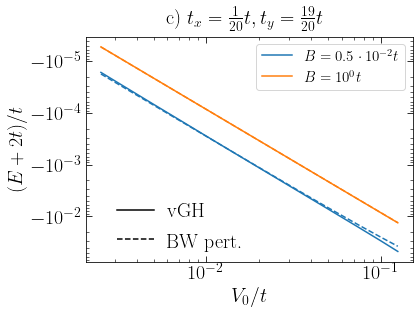

In [17]:
A = 6
plt.rc('figure', figsize=[46.82 * .5**(.5 * A), 33.11 * .5**(.5 * A)])
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
font_size = 20

fig, axs = plt.subplots()

plt.suptitle(r'c) $t_x=\frac{1}{20}t,t_y=\frac{19}{20}t$', fontsize=font_size)

axs.plot(V_0_range[1:24]/t, E_to_plot(E_vGH3_B_1.real,t)[1:24], color='tab:blue', linestyle='solid', label=r'$B = 0.5\cdot 10^{-2} t$')
axs.plot(V_0_range[1:24]/t, E_to_plot(E_pert3_B_1.real,t)[1:24], color='tab:blue', linestyle='dashed')

axs.plot(V_0_range[1:24]/t, E_to_plot(E_vGH3_B_200.real,t)[1:24], color='tab:orange', linestyle='solid', label=r'$B = 10^0 t$')
axs.plot(V_0_range[1:24]/t, E_to_plot(E_pert3_B_200.real,t)[1:24], color='tab:orange', linestyle='dashed')

plt.xlabel(r'$V_0/t$', fontsize=font_size)
plt.ylabel(r'$(E+2t)/t$', fontsize=font_size)


plt.xticks(fontsize=font_size)
plt.yticks(fontsize=font_size)

axs.set_xscale('log', base=10)
axs.set_yscale('log', base=10)

axs.invert_yaxis()
axs.set_yticks([1e-1,1e-2,1e-3,1e-4,1e-5],[r'$-10^{-1}$',r'$-10^{-2}$',r'$-10^{-3}$',r'$-10^{-4}$',r'$-10^{-5}$'], fontsize=font_size)

axs.plot(np.linspace(3.1e-3,5e-3,100), 0.75e-2*np.ones(100), linestyle='solid', color='black')
axs.plot(np.linspace(3.1e-3,5e-3,100), 0.27e-1*np.ones(100), linestyle='dashed', color='black')

axs.annotate('vGH', xy=(0.6*1e-2,1e-2), fontsize=font_size)
axs.annotate('BW pert.', xy=(0.6*1e-2,0.4e-1), fontsize=font_size)

axs.legend(fontsize=15, loc=1)

plt.tick_params(axis='x', direction='in', length=6, top=True)
plt.tick_params(axis='y', direction='in', length=6, right=True)
plt.tick_params(axis='x', which='minor', direction='in', length=3, top=True)
plt.tick_params(axis='y', which='minor', direction='in', length=3, right=True)

plt.tick_params(which='minor', axis='y', direction='in', right=True)
plt.savefig('results/perturbation_theory/B_comp_tx_10_ty_190.svg', bbox_inches='tight')

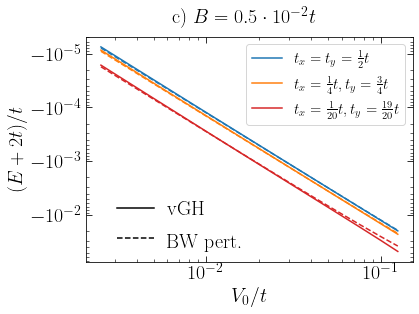

In [18]:
A = 6
plt.rc('figure', figsize=[46.82 * .5**(.5 * A), 33.11 * .5**(.5 * A)])
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
font_size = 20

fig, axs = plt.subplots()

plt.suptitle(r'c) $B = 0.5\cdot 10^{-2}t$', fontsize=font_size)

axs.plot(V_0_range[1:24]/t, E_to_plot(E_vGH1_B_1.real,t)[1:24], color='tab:blue', linestyle='solid', label=r'$t_x=t_y=\frac{1}{2}t$')
axs.plot(V_0_range[1:24]/t, E_to_plot(E_pert1_B_1.real,t)[1:24], color='tab:blue', linestyle='dashed')

axs.plot(V_0_range[1:24]/t, E_to_plot(E_vGH2_B_1.real,t)[1:24], color='tab:orange', linestyle='solid', label=r'$t_x=\frac{1}{4}t,t_y=\frac{3}{4}t$')
axs.plot(V_0_range[1:24]/t, E_to_plot(E_pert2_B_1.real,t)[1:24], color='tab:orange', linestyle='dashed')

axs.plot(V_0_range[1:24]/t, E_to_plot(E_vGH3_B_1.real,t)[1:24], color='tab:red', linestyle='solid', label=r'$t_x=\frac{1}{20}t,t_y=\frac{19}{20}t$')
axs.plot(V_0_range[1:24]/t, E_to_plot(E_pert3_B_1.real,t)[1:24], color='tab:red', linestyle='dashed')


plt.xlabel(r'$V_0/t$', fontsize=font_size)
plt.ylabel(r'$(E+2t)/t$', fontsize=font_size)


plt.xticks(fontsize=font_size)
plt.yticks(fontsize=font_size)

axs.set_xscale('log', base=10)
axs.set_yscale('log', base=10)

axs.invert_yaxis()
axs.set_yticks([1e-1,1e-2,1e-3,1e-4,1e-5],[r'$-10^{-1}$',r'$-10^{-2}$',r'$-10^{-3}$',r'$-10^{-4}$',r'$-10^{-5}$'], fontsize=font_size)

axs.plot(np.linspace(3.1e-3,5e-3,100), 0.75e-2*np.ones(100), linestyle='solid', color='black')
axs.plot(np.linspace(3.1e-3,5e-3,100), 0.27e-1*np.ones(100), linestyle='dashed', color='black')

axs.annotate('vGH', xy=(0.6*1e-2,1e-2), fontsize=font_size)
axs.annotate('BW pert.', xy=(0.6*1e-2,0.4e-1), fontsize=font_size)

axs.legend(fontsize=15, loc=1)

plt.tick_params(axis='x', direction='in', length=6, top=True)
plt.tick_params(axis='y', direction='in', length=6, right=True)
plt.tick_params(axis='x', which='minor', direction='in', length=3, top=True)
plt.tick_params(axis='y', which='minor', direction='in', length=3, right=True)

plt.tick_params(which='minor', axis='y', direction='in', right=True)
plt.savefig('results/perturbation_theory/sym_comp_B_0.01t.svg', bbox_inches='tight')

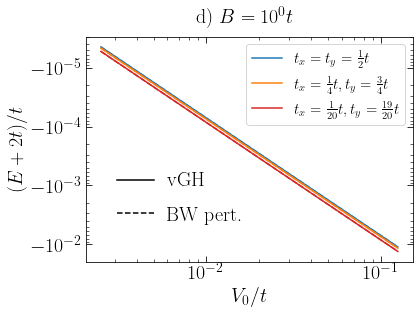

In [41]:
A = 6
plt.rc('figure', figsize=[46.82 * .5**(.5 * A), 33.11 * .5**(.5 * A)])
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
font_size = 20

fig, axs = plt.subplots()

plt.suptitle(r'd) $B = 10^{0}t$', fontsize=font_size)

axs.plot(V_0_range[1:24]/t, E_to_plot(E_vGH1_B_200.real,t)[1:24], color='tab:blue', linestyle='solid', label=r'$t_x=t_y=\frac{1}{2}t$')
axs.plot(V_0_range[1:24]/t, E_to_plot(E_pert1_B_200.real,t)[1:24], color='tab:blue', linestyle='dashed')

axs.plot(V_0_range[1:24]/t, E_to_plot(E_vGH2_B_200.real,t)[1:24], color='tab:orange', linestyle='solid', label=r'$t_x=\frac{1}{4}t,t_y=\frac{3}{4}t$')
axs.plot(V_0_range[1:24]/t, E_to_plot(E_pert2_B_200.real,t)[1:24], color='tab:orange', linestyle='dashed')

axs.plot(V_0_range[1:24]/t, E_to_plot(E_vGH3_B_200.real,t)[1:24], color='tab:red', linestyle='solid', label=r'$t_x=\frac{1}{20}t,t_y=\frac{19}{20}t$')
axs.plot(V_0_range[1:24]/t, E_to_plot(E_pert3_B_200.real,t)[1:24], color='tab:red', linestyle='dashed')


plt.xlabel(r'$V_0/t$', fontsize=font_size)
plt.ylabel(r'$(E+2t)/t$', fontsize=font_size)

plt.xticks(fontsize=font_size)
plt.yticks(fontsize=font_size)

axs.set_xscale('log', base=10)
axs.set_yscale('log', base=10)

axs.invert_yaxis()
axs.set_yticks([1e-1,1e-2,1e-3,1e-4,1e-5],[r'$-10^{-1}$',r'$-10^{-2}$',r'$-10^{-3}$',r'$-10^{-4}$',r'$-10^{-5}$'], fontsize=font_size)

axs.plot(np.linspace(3.1e-3,5e-3,100), 0.8e-3*np.ones(100), linestyle='solid', color='black')
axs.plot(np.linspace(3.1e-3,5e-3,100), 0.3e-2*np.ones(100), linestyle='dashed', color='black')

axs.annotate('vGH', xy=(0.6*1e-2,1e-3), fontsize=font_size)
axs.annotate('BW pert.', xy=(0.6*1e-2,0.4e-2), fontsize=font_size)

axs.legend(fontsize=15, loc=1)

plt.tick_params(axis='x', direction='in', length=6, top=True)
plt.tick_params(axis='y', direction='in', length=6, right=True)
plt.tick_params(axis='x', which='minor', direction='in', length=3, top=True)
plt.tick_params(axis='y', which='minor', direction='in', length=3, right=True)

plt.tick_params(which='minor', axis='y', direction='in', right=True)
plt.savefig('results/perturbation_theory/sym_comp_B_t.svg', bbox_inches='tight')

In [20]:
plt.plot(V_0_range/t, E_to_plot(E_pert1.real,t), marker='x', color='tab:blue', linestyle='solid', label=r'$t_x = 100, t_y = 100$')
plt.plot(V_0_range/t, E_to_plot(E_vGH1.real,t), marker='x', color='tab:blue', linestyle='dashed')
plt.plot(V_0_range/t, (1/(1*(1+4*t))**0.5)*V_0_range**2/t, marker='x', color='tab:green', linestyle='dashed')


plt.xscale('log')
plt.yscale('log')

NameError: name 'E_pert1' is not defined

In [ ]:
plt.plot(V_0_range/t, 2*(0.5*(1/(1*(1+4*200))**0.5)*(V_0_range)**2)/t, marker='x', color='tab:green', linestyle='dashed')
plt.plot(V_0_range/t, (0.5*(1/(1*(1+4*200))**0.5)*(V_0_range)**2)/t, marker='x', color='tab:green', linestyle='dashed')

plt.xscale('log')
plt.yscale('log')

In [ ]:
V_0_range = np.linspace(0,10,3)

params["tol"] = 1e-8

params["tx"] = 100
params["ty"] = 100
t = params["tx"] + params["ty"]
E_pert1, E_vGH1 = get_energies(params,V_0_range)

print(E_pert1-E_vGH1)

### Effective Mass Calculations

In [21]:
def eff_mass_V_0_range(V_0_eff_mass_range, params):
    h = 1e-3
    
    eff_mass_x_arr = np.zeros(len(V_0_eff_mass_range))
    eff_mass_y_arr = np.zeros(len(V_0_eff_mass_range))
    for i in range(len(V_0_eff_mass_range)):
        V_0 = V_0_eff_mass_range[i]
    
        self_E_prime = find_first_deriv_self_energy(V_0, params["tx"], params["ty"], params["B"], h)
        eff_mass_x, eff_mass_y = calc_eff_mass(self_E_prime, V_0, params["tx"], params["ty"], params["B"])

        eff_mass_x_arr[i] = eff_mass_x
        eff_mass_y_arr[i] = eff_mass_y
        
        print('V_0,eff_mass =', V_0, eff_mass_x, eff_mass_y)
    return eff_mass_x_arr, eff_mass_y_arr

In [22]:
V_0_range1 = np.linspace(0,10,21) 
V_0_range2 = np.linspace(15,100,18)

V_0_eff_mass_range = np.append(V_0_range1, V_0_range2)

params["B"] = 2
params["tx"] = 100
params["ty"] = 100 
print('Eff Mass cal for B = ', params["B"], ':\n')
eff_mass1_x_B_2, eff_mass1_y_B_2 = eff_mass_V_0_range(V_0_eff_mass_range, params)

params["B"] = 200
params["tx"] = 100
params["ty"] = 100
print('\nEff Mass cal for B = ', params["B"], ':\n')
eff_mass1_x_B_200, eff_mass1_y_B_200 = eff_mass_V_0_range(V_0_eff_mass_range, params)

Eff Mass cal for B =  2 :

V_0,eff_mass = 0.0 0.005 0.005
V_0,eff_mass = 0.5 0.005000053377540167 0.005000053377540167
V_0,eff_mass = 1.0 0.0050002134160955815 0.0050002134160955815
V_0,eff_mass = 1.5 0.005000479848999432 0.005000479848999432
V_0,eff_mass = 2.0 0.005000852168317626 0.005000852168317626
V_0,eff_mass = 2.5 0.0050013297742615755 0.0050013297742615755
V_0,eff_mass = 3.0 0.005001911838663851 0.005001911838663851
V_0,eff_mass = 3.5 0.00500259738609078 0.00500259738609078
V_0,eff_mass = 4.0 0.005003385290122508 0.005003385290122508
V_0,eff_mass = 4.5 0.00500427428523154 0.00500427428523154
V_0,eff_mass = 5.0 0.005005262979608187 0.005005262979608187
V_0,eff_mass = 5.5 0.00500634986860988 0.00500634986860988
V_0,eff_mass = 6.0 0.005007533348553151 0.005007533348553151
V_0,eff_mass = 6.5 0.005008811730569912 0.005008811730569912
V_0,eff_mass = 7.0 0.005010183254324202 0.005010183254324202
V_0,eff_mass = 7.5 0.005011646101221892 0.005011646101221892
V_0,eff_mass = 8.0 0.00501319

In [32]:
def eff_mass_to_plot(eff_mass, eff_mass_0):
    return eff_mass/eff_mass_0 - 1

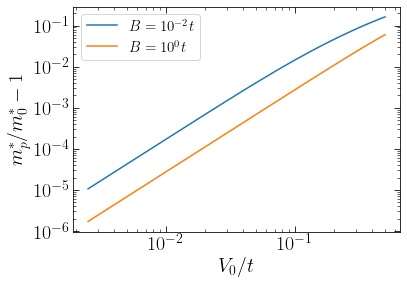

In [43]:
tx = 100
ty = 100

eff_mass_x_0 = 1/(2*tx)
eff_mass_y_0 = 1/(2*ty)

A = 6
plt.rc('figure', figsize=[46.82 * .5**(.5 * A), 33.11 * .5**(.5 * A)])
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
font_size = 20

fig, axs = plt.subplots()

plt.plot(V_0_eff_mass_range[1:]/t, eff_mass_to_plot(eff_mass1_x_B_2, eff_mass_x_0)[1:], label=r'$B = 10^{-2}t$')
plt.plot(V_0_eff_mass_range[1:]/t, eff_mass_to_plot(eff_mass1_x_B_200, eff_mass_y_0)[1:], label=r'$B = 10^{0}t$')

plt.xlabel(r'$V_0/t$', fontsize=font_size)
plt.ylabel(r'$m^*_p/m^*_0 - 1$', fontsize=font_size)

plt.xticks(fontsize=font_size)
plt.yticks(fontsize=font_size)

axs.set_xscale('log', base=10)
axs.set_yscale('log', base=10)

axs.legend(fontsize=15, loc=2)

plt.tick_params(axis='x', direction='in', length=6, top=True)
plt.tick_params(axis='y', direction='in', length=6, right=True)
plt.tick_params(axis='x', which='minor', direction='in', length=3, top=True)
plt.tick_params(axis='y', which='minor', direction='in', length=3, right=True)

plt.tick_params(which='minor', axis='y', direction='in', right=True)
plt.savefig('results/perturbation_theory/pert_eff_mass_tx_100_ty_100.svg', bbox_inches='tight')

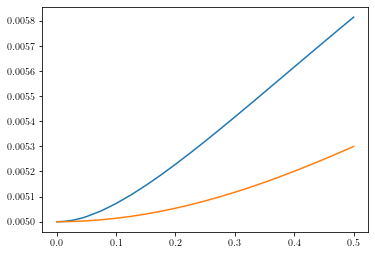

In [47]:
plt.plot(V_0_eff_mass_range/t, eff_mass1_x_B_2)
plt.plot(V_0_eff_mass_range/t, eff_mass1_x_B_200)